### Notebook de prueba en Colab

Este es un notebook de prueba en Google Colab.

In [ ]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import requests
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import numpy as np
from io import BytesIO
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import time

In [ ]:
BASE_URL = "https://www.vgamuseum.info/index.php/cards"

def fetch_html_vgamuseum(url):
    """Descarga y devuelve el HTML de una URL del sitio vgamuseum.info"""
    try:
        r = requests.get(url, timeout=10)
        r.raise_for_status()
        return r.text
    except Exception as e:
        print(f"❌ Error al acceder a {url}: {e}")
        return None


def extract_category_links_vgamuseum(base_url):
    """Extrae todos los enlaces a categorías principales desde /cards"""
    html = fetch_html_vgamuseum(base_url)
    if not html:
        return []

    soup = BeautifulSoup(html, "html.parser")
    fulltext_div = soup.find("div", class_="itemFullText")
    if not fulltext_div:
        print("⚠️ No se encontró div.itemFullText en la página principal.")
        return []

    category_links = []
    for li in fulltext_div.find_all("li"):
        a_tag = li.find("a", href=True)
        if a_tag:
            full_url = urljoin(base_url, a_tag["href"])
            category_links.append(full_url)
    print(f"🔗 Encontradas {len(category_links)} categorías.")
    return category_links


def extract_subcategory_links_vgamuseum(category_url):
    """
    Extrae las subpáginas de tarjetas (por modelo o serie) dentro de una categoría,
    gestionando la paginación localizada en 'ul.pagination-list a.pagenav'.
    """
    html = fetch_html_vgamuseum(category_url)
    if not html:
        return []

    soup = BeautifulSoup(html, "html.parser")

    # 1️⃣ Obtener todas las URLs de paginación (incluyendo la página inicial)
    pagination_urls = [category_url]
    pagination_section = soup.select("ul.pagination-list a.pagenav")

    for a_tag in pagination_section:
        page_url = urljoin(category_url, a_tag["href"])
        if page_url not in pagination_urls:
            pagination_urls.append(page_url)

    print(f"  📁 {len(pagination_urls)} páginas de subcategorías encontradas en {category_url}")

    # 2️⃣ Iterar por todas las páginas (original + paginadas) y extraer subpáginas
    sub_links = []
    for page_url in pagination_urls:
        html_page = fetch_html_vgamuseum(page_url)
        if not html_page:
            continue

        soup_page = BeautifulSoup(html_page, "html.parser")

        for h3 in soup_page.find_all("h3", class_="catItemTitle"):
            a_tag = h3.find("a", href=True)
            if a_tag:
                full_url = urljoin(page_url, a_tag["href"])
                sub_links.append(full_url)

    print(f"  📁 {len(sub_links)} subcategorías encontradas en {category_url} (paginación incluida)")
    return sub_links


def extract_images_from_subpage_vgamuseum(sub_url):
    """
    Extrae todas las imágenes JPG dentro de div.itemFullText,
    descarta las que contengan 'driv' y devuelve también el título
    (h2.itemTitle dentro de div.itemHeader).
    """
    html = fetch_html_vgamuseum(sub_url)
    if not html:
        return []

    soup = BeautifulSoup(html, "html.parser")

    # 🔹 Obtener el título de la subpágina
    title = None
    header_div = soup.find("div", class_="itemHeader")
    if header_div:
        title_tag = header_div.find("h2", class_="itemTitle")
        if title_tag:
            title = title_tag.get_text(strip=True)

    fulltext_divs = soup.find_all("div", class_="itemFullText")
    images = []

    for div in fulltext_divs:
        for a_tag in div.find_all("a", href=True):
            href = a_tag["href"]
            if href.lower().endswith(".jpg"):
                img_url = urljoin(sub_url, href)

                # Descartar imágenes relacionadas con drivers
                if "driv" in img_url.lower() or "drv" in img_url.lower() or "driver" in img_url.lower():
                    print(f"    ⚠️ Descartada imagen de drivers: {img_url}")
                    continue

                images.append({
                    "title": title or "Sin título",
                    "image_url": img_url
                })

    if images:
        print(f"    🖼️ {len(images)} imágenes válidas encontradas en {sub_url} — {title or 'Sin título'}")
    return images


def scrape_vgamuseum_cards(base_url):
    """Scraper principal para recorrer todo el árbol de categorías y subcategorías con paginación"""
    all_data = []

    categories = extract_category_links_vgamuseum(base_url)

    print(f"\n🔎 Recuperadas {len(categories)} categorías principales.")

    included_categories = [
        "https://www.vgamuseum.info/index.php/cards/itemlist/category/31-s3-graphics",
        "https://www.vgamuseum.info/index.php/cards/itemlist/category/2-3dfx",
        "https://www.vgamuseum.info/index.php/cards/itemlist/category/22-matrox",
        "https://www.vgamuseum.info/index.php/cards/itemlist/category/9-ati-technologies-inc",
        "https://www.vgamuseum.info/index.php/cards/itemlist/category/27-nvidia-corporation",
        "https://www.vgamuseum.info/index.php/cards/itemlist/category/39-trident-microsystems-inc"
    ]

    for cat_url in categories:
        if cat_url not in included_categories:
            continue

        sub_links = extract_subcategory_links_vgamuseum(cat_url)
        for sub_url in sub_links:
            images = extract_images_from_subpage_vgamuseum(sub_url)

            category_from_url = cat_url.split("/")[-1]
            category = "-".join(category_from_url.split("-")[1:])

            for img_info in images:
                all_data.append({
                    "category": category,
                    "category_url": cat_url,
                    "subpage_url": sub_url,
                    "title": img_info["title"],
                    "image_url": img_info["image_url"]
                })
            time.sleep(1)  # evita sobrecargar el servidor

    return all_data


# Ejecutar el scraping completo (sin guardar CSV)
cards = scrape_vgamuseum_cards(BASE_URL)

print(f"\n✅ Total de imágenes encontradas: {len(cards)}")
print("Ejemplo de resultados en memoria:")
for c in cards[:20]:
    print(f"- {c['category']} - {c['title']} - {c['image_url']}")


🔗 Encontradas 61 categorías.

🔎 Recuperadas 61 categorías principales.
  📁 1 páginas de subcategorías encontradas en https://www.vgamuseum.info/index.php/cards/itemlist/category/2-3dfx
  📁 11 subcategorías encontradas en https://www.vgamuseum.info/index.php/cards/itemlist/category/2-3dfx (paginación incluida)
    🖼️ 4 imágenes válidas encontradas en https://www.vgamuseum.info/index.php/cards/item/10-3dfx-voodoo-5-5500 — 3Dfx Voodoo 5 5500
    🖼️ 4 imágenes válidas encontradas en https://www.vgamuseum.info/index.php/cards/item/1046-3dfx-voodoo-4-4500 — 3Dfx Voodoo 4 4500
    🖼️ 3 imágenes válidas encontradas en https://www.vgamuseum.info/index.php/cards/item/8-3dfx-voodoo-3-3500 — 3Dfx Voodoo 3 3500
    🖼️ 17 imágenes válidas encontradas en https://www.vgamuseum.info/index.php/cards/item/7-3dfx-voodoo-3-3000 — 3Dfx Voodoo 3 3000
    🖼️ 14 imágenes válidas encontradas en https://www.vgamuseum.info/index.php/cards/item/6-3dfx-voodoo-3-2000 — 3Dfx Voodoo 3 2000
    🖼️ 2 imágenes válidas en

In [ ]:
def download_images_as_binary(cards):
    """
    Dada una lista de diccionarios con 'title' y 'url',
    descarga cada imagen y devuelve una lista con (title, img_binary).
    """
    downloaded = []

    for card in cards:
        category = card.get("category")
        url = card.get("image_url")

        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            img_binary = BytesIO(response.content)
            downloaded.append((category, img_binary))
            print(f"Descargada: {category} ({url})")

        except Exception as e:
            print(f"⚠️ No se pudo descargar {url}: {e}")

    return downloaded


In [ ]:
binary_cards = download_images_as_binary(cards)
print(f"Total tarjetas descargadas: {len(binary_cards)}")

Descargada: 3dfx (https://www.vgamuseum.info/images/vlask/3dfx/v5500fb.jpg)
Descargada: 3dfx (https://www.vgamuseum.info/images/vlask/3dfx/v5500fzb.jpg)
Descargada: 3dfx (https://www.vgamuseum.info/images/palcal/3dfx/788_3dfx_voodoo_5_5500_top_hq.jpg)
Descargada: 3dfx (https://www.vgamuseum.info/images/palcal/3dfx/788_3dfx_voodoo_5_5500_bottom_hq.jpg)
Descargada: 3dfx (https://www.vgamuseum.info/images/pepino/3dfx/3dfx_voodoo4_4500_f.jpg)
Descargada: 3dfx (https://www.vgamuseum.info/images/pepino/3dfx/3dfx_voodoo4_4500_b.jpg)
Descargada: 3dfx (https://www.vgamuseum.info/images/demiurge/minime/img520.jpg)
Descargada: 3dfx (https://www.vgamuseum.info/images/demiurge/minime/img521.jpg)
Descargada: 3dfx (https://www.vgamuseum.info/images/vlask/3dfx/v33500f.jpg)
Descargada: 3dfx (https://www.vgamuseum.info/images/vlask/3dfx/v33500fz.jpg)
Descargada: 3dfx (https://www.vgamuseum.info/images/vlask/3dfx/v33500cable.jpg)
Descargada: 3dfx (https://www.vgamuseum.info/images/vlask/3dfx/v33000fb.jpg

In [ ]:
def get_image_size_stats(binary_images):
    """
    Calcula el tamaño mínimo y máximo (ancho y alto) de una lista de imágenes.
    binary_images: lista de tuplas (title, img_binary)
    """
    widths, heights = [], []

    for category, img_binary in binary_images:
        try:
            with Image.open(img_binary) as img:
                w, h = img.size
                widths.append(w)
                heights.append(h)
        except Exception as e:
            print(f"⚠️ No se pudo abrir imagen '{category}': {e}")

    if not widths or not heights:
        print("❌ No se pudo calcular tamaños.")
        return None

    stats = {
        "min_width": min(widths),
        "max_width": max(widths),
        "min_height": min(heights),
        "max_height": max(heights),
        "count": len(widths)
    }

    print(f"📊 Total imágenes analizadas: {stats['count']}")
    print(f"📏 Ancho -> min: {stats['min_width']}, max: {stats['max_width']}")
    print(f"📐 Alto  -> min: {stats['min_height']}, max: {stats['max_height']}")

    return stats


In [ ]:
stats = get_image_size_stats(binary_cards)

📊 Total imágenes analizadas: 4594
📏 Ancho -> min: 241, max: 8000
📐 Alto  -> min: 191, max: 4647


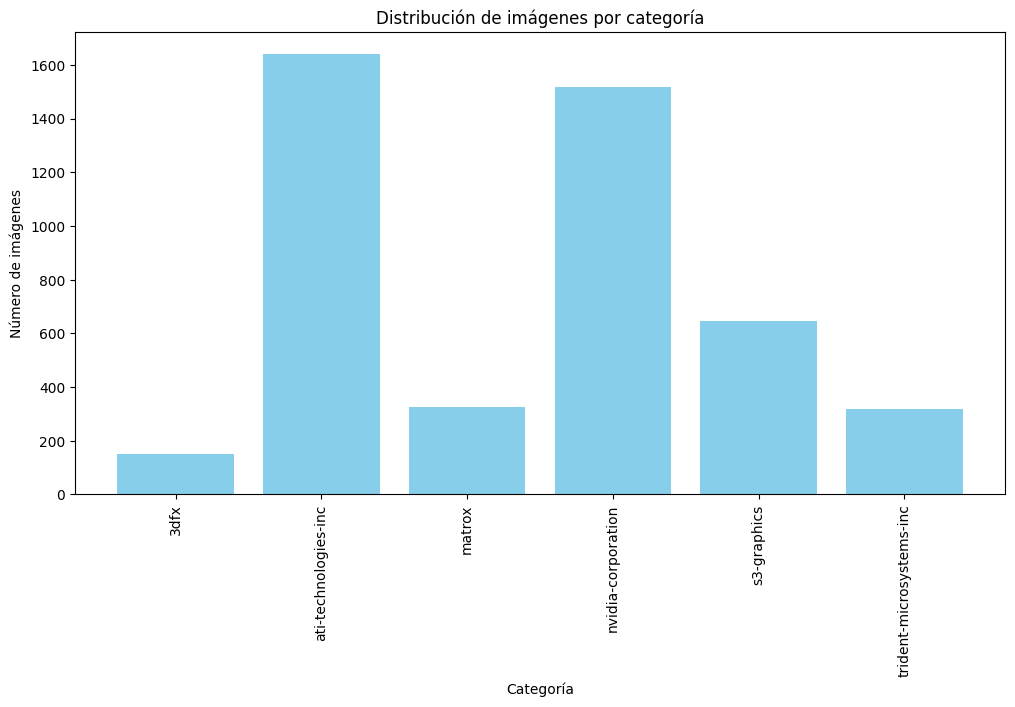

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# binary_images: lista de tuplas (categoria, img_binary)
categories = [cat for cat, img in binary_cards]

# Contar cuántas imágenes hay por categoría
counter = Counter(categories)

# Preparar datos para la gráfica
cats = list(counter.keys())
counts = list(counter.values())

# Graficar
plt.figure(figsize=(12, 6))
plt.bar(cats, counts, color='skyblue')
plt.xticks(rotation=90)
plt.ylabel("Número de imágenes")
plt.xlabel("Categoría")
plt.title("Distribución de imágenes por categoría")
plt.show()

In [ ]:
from google.colab import drive

"""guardar en google drive"""
drive.mount('/content/drive')

# Guardar en Drive
import pickle
with open("/content/drive/MyDrive/binary_cards.pkl", "wb") as f:
    pickle.dump(binary_cards, f)

Mounted at /content/drive


In [ ]:
from google.colab import drive
import pickle

# Montar Google Drive
drive.mount('/content/drive')

# Cargar el objeto pickle
file_path = "/content/drive/MyDrive/binary_cards.pkl"
with open(file_path, "rb") as f:
    binary_cards = pickle.load(f)

print(f"✅ Recuperadas {len(binary_cards)} imágenes y etiquetas.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Recuperadas 4594 imágenes y etiquetas.


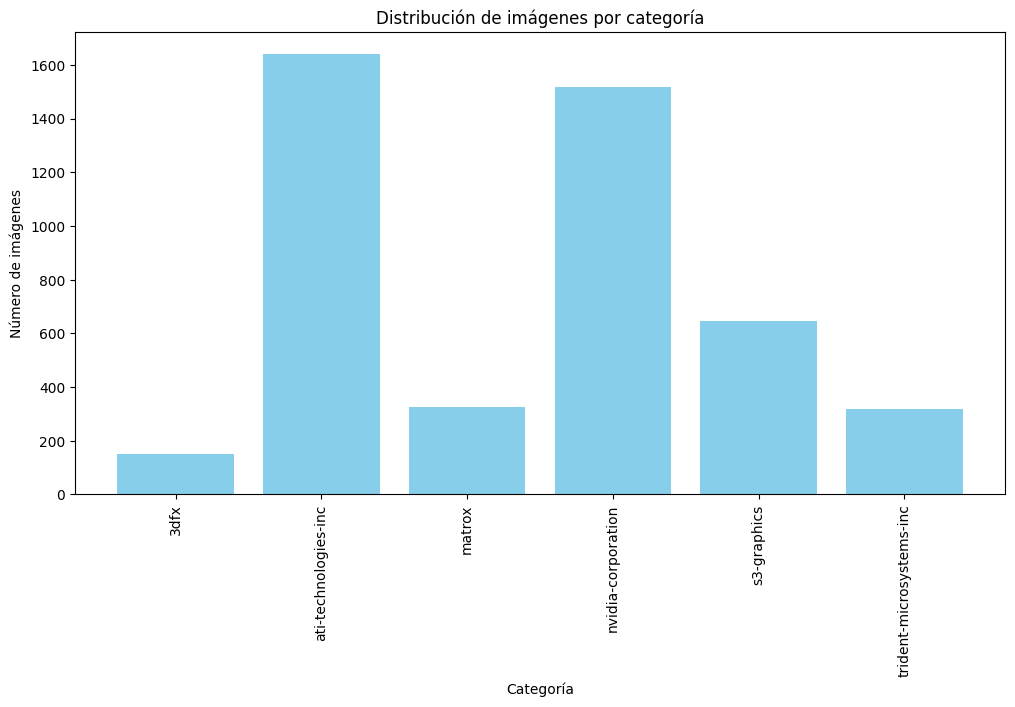

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# binary_images: lista de tuplas (categoria, img_binary)
categories = [cat for cat, img in binary_cards]

# Contar cuántas imágenes hay por categoría
counter = Counter(categories)

# Preparar datos para la gráfica
cats = list(counter.keys())
counts = list(counter.values())

# Graficar
plt.figure(figsize=(12, 6))
plt.bar(cats, counts, color='skyblue')
plt.xticks(rotation=90)
plt.ylabel("Número de imágenes")
plt.xlabel("Categoría")
plt.title("Distribución de imágenes por categoría")
plt.show()

In [ ]:
# Bloque listo para Colab: resize seguro de imágenes a 224x224 y salida en bytes (JPEG)
import io
from PIL import Image
from tqdm import tqdm  # opcional para progreso, instala con `pip install tqdm` si falta

def resize_image_bytes(img_input, size=(224, 224), jpeg_quality=90):
    """
    Recibe img_input (bytes o io.BytesIO), convierte a RGB, redimensiona y devuelve bytes JPEG.
    size: (width, height)
    jpeg_quality: calidad JPEG (0-100)
    """
    # Acepta bytes o BytesIO
    if isinstance(img_input, io.BytesIO):
        buf = img_input
    elif isinstance(img_input, (bytes, bytearray)):
        buf = io.BytesIO(img_input)
    else:
        raise TypeError(f"Tipo de imagen no soportado: {type(img_input)}")

    # Abrir y procesar
    with Image.open(buf) as img:
        img = img.convert("RGB")            # asegurar 3 canales
        img = img.resize(size, Image.LANCZOS)  # redimensionar con buen interpolador

        out_buf = io.BytesIO()
        img.save(out_buf, format="JPEG", quality=jpeg_quality)
        return out_buf.getvalue()


# Ejemplo: procesar toda la lista binary_images => resized_binary_images
# binary_images es: [(category, img_bytes), ...]
def resize_all_binary_images(binary_images, size=(224,224), jpeg_quality=90, show_progress=True):
    """
    Recorre binary_images y devuelve nueva lista con imágenes redimensionadas.
    Procesa secuencialmente para no subir mucho la memoria.
    """
    resized = []
    iterator = tqdm(binary_images) if show_progress else binary_images

    for category, img_bin in iterator:
        try:
            new_bytes = resize_image_bytes(img_bin, size=size, jpeg_quality=jpeg_quality)
            resized.append((category, new_bytes))
        except Exception as e:
            # Si falla una imagen, la omitimos y avisamos
            print(f"⚠️ Error resize '{category}': {e}")
            # opcional: seguir o añadir un placeholder; aquí la omitimos
            continue

    return resized


# -----------------------
# Uso:
# -----------------------
# Suponiendo que ya tienes binary_images cargado en memoria
binary_cards = resize_all_binary_images(binary_cards, size=(224,224), jpeg_quality=90)
print(f"✅ Redimensionadas {len(binary_cards)} imágenes.")


100%|██████████| 4594/4594 [07:35<00:00, 10.09it/s]

✅ Redimensionadas 4594 imágenes.


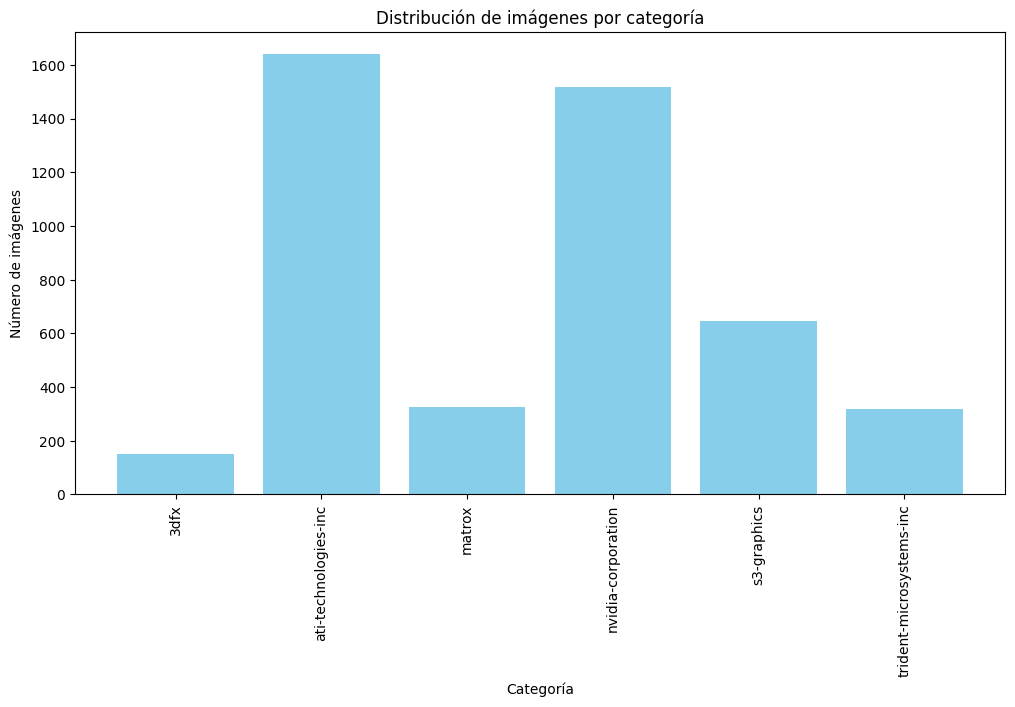

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# binary_images: lista de tuplas (categoria, img_binary)
categories = [cat for cat, img in binary_cards]

# Contar cuántas imágenes hay por categoría
counter = Counter(categories)

# Preparar datos para la gráfica
cats = list(counter.keys())
counts = list(counter.values())

# Graficar
plt.figure(figsize=(12, 6))
plt.bar(cats, counts, color='skyblue')
plt.xticks(rotation=90)
plt.ylabel("Número de imágenes")
plt.xlabel("Categoría")
plt.title("Distribución de imágenes por categoría")
plt.show()

In [ ]:
import io
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from tqdm import tqdm

def augment_minority_classes(binary_images, target_count=1600, size=(224, 224)):
    """
    Aumenta las clases minoritarias hasta alcanzar 'target_count' imágenes.
    Usa ImageDataGenerator para generar nuevas muestras sintéticas.
    """
    # Contar cuántas imágenes tiene cada categoría
    category_counts = Counter([cat for cat, _ in binary_images])
    print(f"🔍 Distribución original: {category_counts}")

    # Configurar Data Augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Agrupar imágenes por categoría
    grouped = {}
    for category, img_bytes in binary_images:
        grouped.setdefault(category, []).append(img_bytes)

    augmented_images = []
    for category, imgs in tqdm(grouped.items(), desc="🔄 Aumentando clases"):
        count = len(imgs)
        augmented_images.extend([(category, img) for img in imgs])  # imágenes originales

        if count < target_count:
            needed = target_count - count
            print(f"🧩 {category}: {count} → {target_count} (añadiendo {needed})")

            # Convertir imágenes a arrays
            img_arrays = []
            for img_bytes in imgs:
                with Image.open(io.BytesIO(img_bytes)) as img:
                    img = img.convert('RGB').resize(size)
                    img_arrays.append(np.array(img))

            img_arrays = np.array(img_arrays)
            img_arrays = img_arrays / 255.0  # normalización temporal

            # Generar imágenes nuevas
            gen = datagen.flow(img_arrays, batch_size=1)

            for _ in range(needed):
                augmented = next(gen)[0]
                augmented = (augmented * 255).astype(np.uint8)
                img = Image.fromarray(augmented)
                buf = io.BytesIO()
                img.save(buf, format='JPEG', quality=90)
                augmented_images.append((category, buf.getvalue()))

    print(f"✅ Total imágenes tras aumento: {len(augmented_images)}")
    return augmented_images


In [ ]:
binary_cards = augment_minority_classes(binary_cards, target_count=1600)

🔍 Distribución original: Counter({'ati-technologies-inc': 1639, 'nvidia-corporation': 1516, 's3-graphics': 644, 'matrox': 327, 'trident-microsystems-inc': 318, '3dfx': 150})


🔄 Aumentando clases:   0%|          | 0/6 [00:00<?, ?it/s]

🧩 3dfx: 150 → 1600 (añadiendo 1450)


🔄 Aumentando clases:  17%|█▋        | 1/6 [00:26<02:10, 26.05s/it]

🧩 matrox: 327 → 1600 (añadiendo 1273)


🔄 Aumentando clases:  50%|█████     | 3/6 [00:48<00:45, 15.18s/it]

🧩 nvidia-corporation: 1516 → 1600 (añadiendo 84)


🔄 Aumentando clases:  67%|██████▋   | 4/6 [00:56<00:24, 12.43s/it]

🧩 s3-graphics: 644 → 1600 (añadiendo 956)


🔄 Aumentando clases:  83%|████████▎ | 5/6 [01:11<00:13, 13.29s/it]

🧩 trident-microsystems-inc: 318 → 1600 (añadiendo 1282)


🔄 Aumentando clases: 100%|██████████| 6/6 [01:31<00:00, 15.26s/it]

✅ Total imágenes tras aumento: 9639


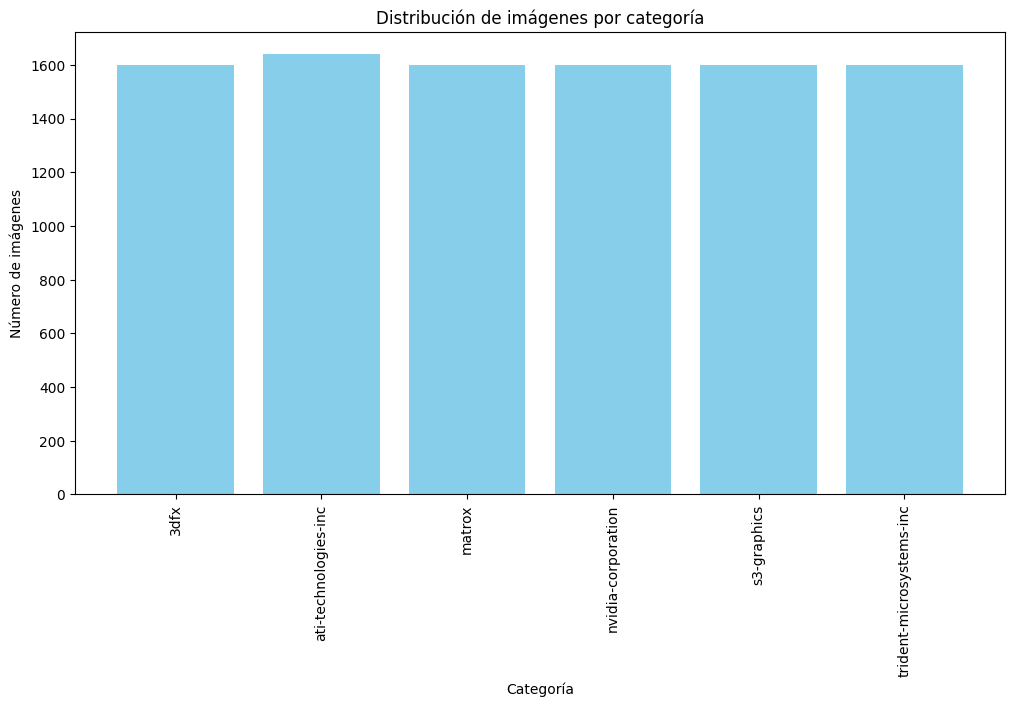

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# binary_images: lista de tuplas (categoria, img_binary)
categories = [cat for cat, img in binary_cards]

# Contar cuántas imágenes hay por categoría
counter = Counter(categories)

# Preparar datos para la gráfica
cats = list(counter.keys())
counts = list(counter.values())

# Graficar
plt.figure(figsize=(12, 6))
plt.bar(cats, counts, color='skyblue')
plt.xticks(rotation=90)
plt.ylabel("Número de imágenes")
plt.xlabel("Categoría")
plt.title("Distribución de imágenes por categoría")
plt.show()

In [ ]:
import io
import random
import matplotlib.pyplot as plt
from PIL import Image

def show_examples_per_category(binary_images, examples_per_category=6, size=(224,224)):
    """
    Muestra una cuadrícula con ejemplos de imágenes por categoría.
    """
    # Agrupar por categoría
    grouped = {}
    for category, img_bytes in binary_images:
        grouped.setdefault(category, []).append(img_bytes)

    # Calcular número de categorías
    num_categories = len(grouped)
    print(f"📸 Mostrando ejemplos de {num_categories} categorías (máx {examples_per_category} por categoría)\n")

    # Mostrar cada categoría
    for category, imgs in grouped.items():
        plt.figure(figsize=(12, 2))
        plt.suptitle(category, fontsize=14)

        # Seleccionar ejemplos aleatorios
        sample_imgs = random.sample(imgs, min(examples_per_category, len(imgs)))

        for i, img_bytes in enumerate(sample_imgs):
            with Image.open(io.BytesIO(img_bytes)) as img:
                img = img.convert("RGB").resize(size)
                plt.subplot(1, examples_per_category, i + 1)
                plt.imshow(img)
                plt.axis("off")

        plt.show()


📸 Mostrando ejemplos de 6 categorías (máx 6 por categoría)



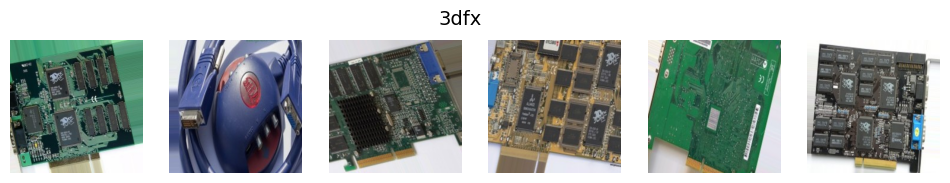

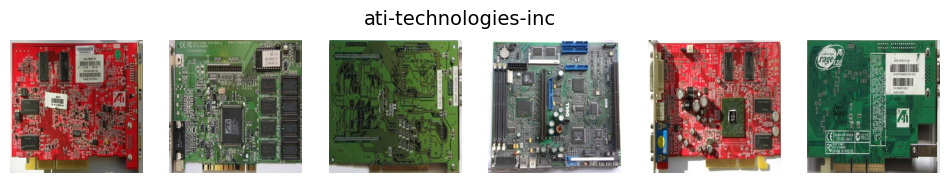

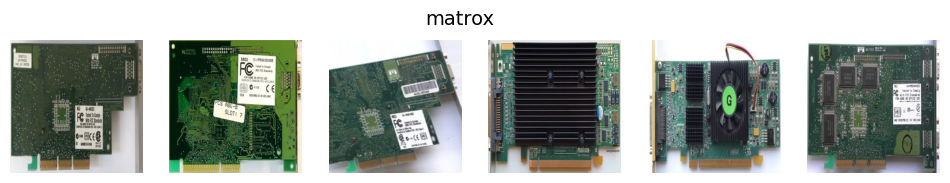

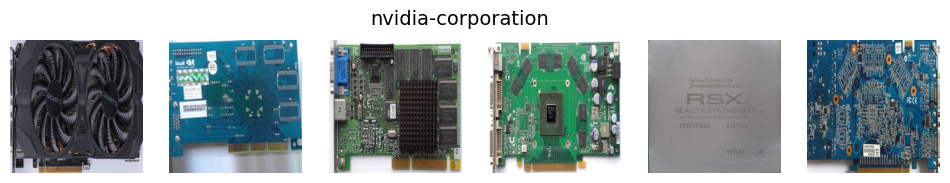

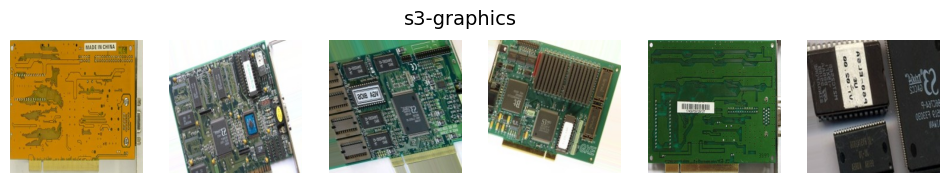

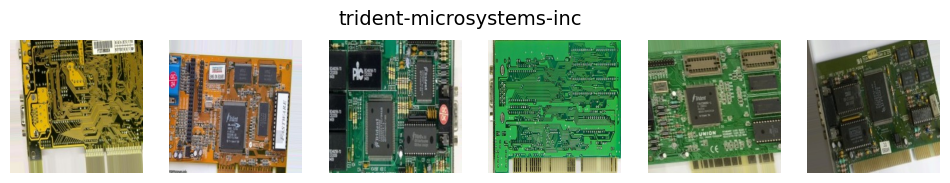

In [ ]:
show_examples_per_category(binary_cards, examples_per_category=6)

In [ ]:
import pickle

with open("/content/drive/MyDrive/binary_cards.pkl", "wb") as f:
    pickle.dump(binary_cards, f)

In [ ]:
from google.colab import drive
import pickle

# Montar Google Drive
drive.mount('/content/drive')

# Cargar el objeto pickle
file_path = "/content/drive/MyDrive/binary_cards.pkl"
with open(file_path, "rb") as f:
    binary_cards = pickle.load(f)

print(f"✅ Recuperadas {len(binary_cards)} imágenes y etiquetas.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Recuperadas 9639 imágenes y etiquetas.


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

def split_dataset(binary_cards, test_size=0.1, val_size=0.1, random_state=42):
    """
    Divide los datos en conjuntos de entrenamiento, validación y test.

    binary_cards: lista de tuplas (categoria, imagen_binaria)
    test_size: proporción del conjunto de test
    val_size: proporción del conjunto de validación
    """
    # Convertir a arrays numpy
    categories, images = zip(*binary_cards)
    categories = np.array(categories)
    images = np.array(images)

    # Dividir en train y test primero
    X_train, X_temp, y_train, y_temp = train_test_split(
        images, categories, test_size=test_size + val_size, stratify=categories, random_state=random_state
    )

    # De lo que quedó, separar validación y test
    relative_val_size = val_size / (test_size + val_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=relative_val_size, stratify=y_temp, random_state=random_state
    )

    print(f"🧠 Train: {len(X_train)} | ✅ Val: {len(X_val)} | 🧪 Test: {len(X_test)}")
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


In [ ]:
(train_X, train_y), (val_X, val_y), (test_X, test_y) = split_dataset(binary_cards, test_size=0.1, val_size=0.1)

🧠 Train: 7711 | ✅ Val: 964 | 🧪 Test: 964


In [ ]:
print("Dimensiones imagenes de entrenamiento: ", train_X.shape)
print("Dimensiones etiquetas de entrenamiento: ", train_y.shape)

print("Dimensiones imagenes de validación: ", val_X.shape)
print("Dimensiones etiquetas de validación: ", val_y.shape)

print("Dimensiones imagenes de test: ", test_X.shape)
print("Dimensiones etiquetas de test: ", test_y.shape)

Dimensiones imagenes de entrenamiento:  (7711,)
Dimensiones etiquetas de entrenamiento:  (7711,)
Dimensiones imagenes de validación:  (964,)
Dimensiones etiquetas de validación:  (964,)
Dimensiones imagenes de test:  (964,)
Dimensiones etiquetas de test:  (964,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Codificar etiquetas a enteros
le = LabelEncoder()
train_y_enc = le.fit_transform(train_y)
val_y_enc = le.transform(val_y)
test_y_enc = le.transform(test_y)

# Convertir a one-hot (para clasificación multiclase)
num_classes = len(le.classes_)
train_y_cat = to_categorical(train_y_enc, num_classes)
val_y_cat = to_categorical(val_y_enc, num_classes)
test_y_cat = to_categorical(test_y_enc, num_classes)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import io
from PIL import Image

def create_generators(train_X, train_y, val_X, val_y, test_X, test_y, batch_size=32):
    # Convertir binarios a arrays de imagen (si no lo hiciste antes)
    def decode_images(X):
        imgs = []
        for img_bytes in X:
            img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
            imgs.append(np.array(img))
        return np.array(imgs)

    X_train = decode_images(train_X)
    X_val = decode_images(val_X)
    X_test = decode_images(test_X)

    # Normalización y aumentación solo para entrenamiento
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    # Generadores
    train_gen = train_datagen.flow(X_train, train_y, batch_size=batch_size)
    val_gen = test_datagen.flow(X_val, val_y, batch_size=batch_size)
    test_gen = test_datagen.flow(X_test, test_y, batch_size=batch_size, shuffle=False)

    return train_gen, val_gen, test_gen


In [ ]:
train_gen, val_gen, test_gen = create_generators(train_X, train_y_cat, val_X, val_y_cat, test_X, test_y_cat)

In [ ]:
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output

"""  reducir dimensiones de salida """
x = tf.keras.layers.GlobalAveragePooling2D()(x)

""" capa densa entrenable """
x = tf.keras.layers.Dense(256, activation='relu')(x)

predictions = tf.keras.layers.Dense(6, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,587,462 (9.87 MB)

 Trainable params: 329,478 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
"""compile model"""
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
"""create early stopping callback"""
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
""" train model"""
history = model.fit(train_gen, epochs=100, validation_data=val_gen, callbacks=[early_stopping])

Epoch 1/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 127s 451ms/step - accuracy: 0.4654 - loss: 1.3763 - val_accuracy: 0.5581 - val_loss: 1.1243
Epoch 2/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 85s 352ms/step - accuracy: 0.6914 - loss: 0.8297 - val_accuracy: 0.6473 - val_loss: 0.9563
Epoch 3/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 84s 347ms/step - accuracy: 0.7539 - loss: 0.6575 - val_accuracy: 0.5643 - val_loss: 1.2225
Epoch 4/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 85s 353ms/step - accuracy: 0.7908 - loss: 0.5672 - val_accuracy: 0.7054 - val_loss: 0.7828
Epoch 5/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 85s 354ms/step - accuracy: 0.8155 - loss: 0.5021 - val_accuracy: 0.7469 - val_loss: 0.7154
Epoch 6/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 85s 351ms/step - accuracy: 0.8244 - loss: 0.4773 - val_accuracy: 0.8039 - val_loss: 0.5646
Epoch 7/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 84s 348ms/step - accuracy: 0.8606 - loss: 0.3881 - val_accuracy: 0.7365 - val_loss: 0.7014
Epoch 8/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 84s 347ms/step - accuracy: 0.8655 

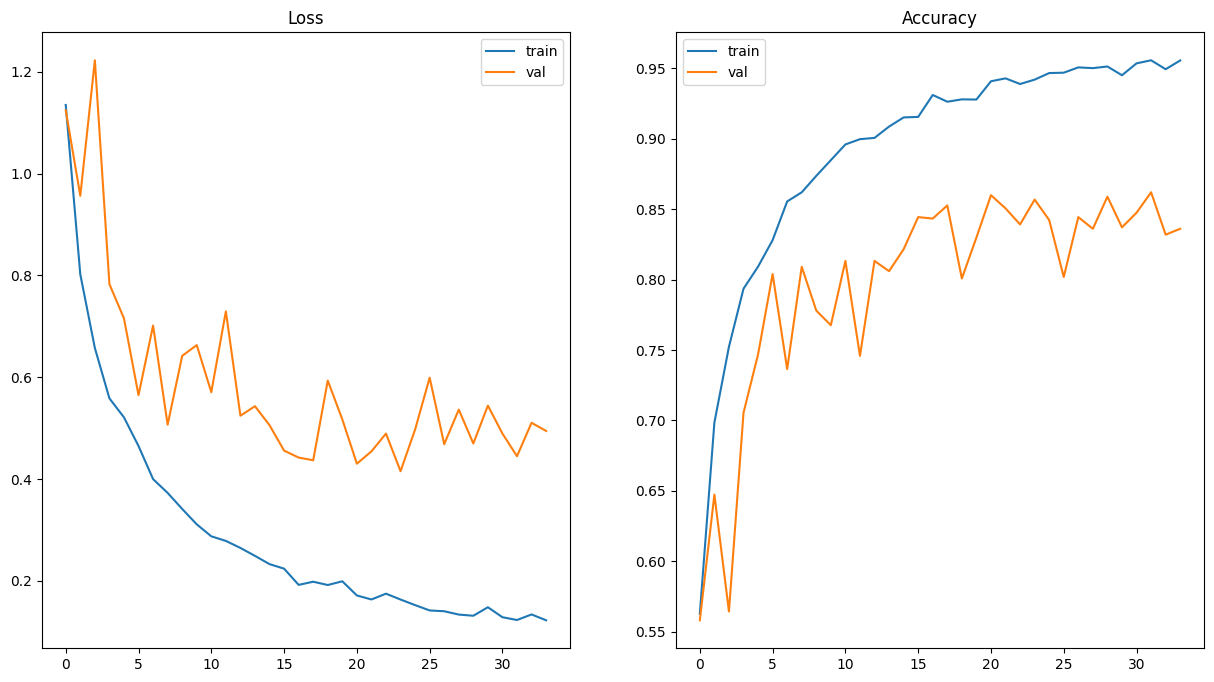

In [ ]:
import matplotlib.pyplot as plt

"""" Grafica de perdida y accurady"""
plt.figure(figsize=[15,8])

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.title('Loss')

"""" Grafica de precision"""
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.title('Accuracy')

plt.show()

In [ ]:
from google.colab import drive
from keras.saving import save_model

# Montar Google Drive
#drive.mount('/content/drive')

# Save model
#model.save("/content/drive/model_graphic_cards_transfer_learning.h5")
save_model(model, "/content/model_graphic_cards_transfer_learning.keras")

In [ ]:
!cp -r /content/model_graphic_cards_transfer_learning.keras /content/drive/MyDrive/

In [ ]:
model.save("/content/drive/MyDrive/model_graphic_cards_transfer_learning.h5")

In [ ]:
_, test_accuracy = model.evaluate(test_gen)
print(f"Test accuracy: {test_accuracy}")

 1/31 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.8438 - loss: 0.4162

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8652 - loss: 0.4550
Test accuracy: 0.8599585294723511
